In [2]:
##要执行的我会在代码段前注释“第i步”
#第一步
import numpy
import pandas as pd
import datetime
import json
import os
import xlrd# 安装xlrd == 1.2.0 版本太高会出错
import numpy as np
import matplotlib.pyplot as plt
import copy
from skyfield.api import load, EarthSatellite
from skyfield.api import wgs84
from matplotlib.pyplot import MultipleLocator
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

## No need to run


In [2]:
def get_allfile(path):  # 获取所有文件
    all_file = []
    for f in os.listdir(path):  #listdir返回文件中所有目录
        f_name = os.path.join(path, f)
        all_file.append(f_name)
    return all_file

In [4]:
key_wanted=["NORAD_CAT_ID","OBJECT_NAME","EPOCH","INCLINATION","TLE_LINE1","TLE_LINE2","SEMIMAJOR_AXIS"]
tickets = r"../../Dataset/all_by_time_2019_5_22_2022_7_20/all_csv"
all_file=get_allfile(tickets)  #tickets要获取文件夹名
for i in range(len(all_file)):#  94,107
    filename=r"%s"%all_file[i]
    if(i == 0):tle_df = pd.read_csv(filename)
    else:
        tle_mid_df = pd.read_csv(filename)
        tle_df = pd.concat([tle_df,tle_mid_df],join='outer',axis=0)

name_list = []
for i in range(len(list(tle_df.columns))):
    if(list(tle_df.columns)[i] not in key_wanted):
        name_list.append(list(tle_df.columns)[i])

tle_df = tle_df.drop(columns=name_list)
# for i in range(len(tle_df)):
#     tle_df.iloc[i,2] = datetime.datetime.strptime(tle_df.iloc[i,2],"%Y-%m-%d %H:%M:%S")

#提取到tle后按“NORAD_CAT_ID”分组，并按EPOCH的逆序排序
tle_group = tle_df.groupby("NORAD_CAT_ID")
object_dict = {}
for dfGroupBy in tle_group:
    df_dict_key = dfGroupBy[0]
    df_dict_value = pd.DataFrame(dfGroupBy[1])
    object_dict[df_dict_key] = df_dict_value.sort_values(by='EPOCH',ascending=False)
#print(starlink_dict['STARLINK-3282'])

In [5]:
list1 = [24793,876,4727,15595,22824]
list2 = [45131,3559,16194,36122]
for key in object_dict.keys():
    #if((key != 48274) and (key != 44971) and (key != 47989)):continue
    if((key not in list1) and (key not in list2)):continue
    object_dict[key]['alltitude'] = ''
    for i in range(len(object_dict[key])):#len(object_dict[key])
        tle_line1 = object_dict[key].iloc[i,4]
        tle_line2 = object_dict[key].iloc[i,5]
        object_dict[key].iloc[i,2] = datetime.datetime.strptime(object_dict[key].iloc[i,2],"%Y-%m-%d %H:%M:%S")
        tle_epoch = object_dict[key].iloc[i,2]
        year = tle_epoch.year
        month = tle_epoch.month
        day = tle_epoch.day
        hour = tle_epoch.hour
        minute = tle_epoch.minute
        second = tle_epoch.second

        ts = load.timescale()
        sat = EarthSatellite(tle_line1,tle_line2,None,ts)
        t = ts.utc(year,month,day,hour,minute,second)
        geocentric = sat.at(t)
        h = wgs84.height_of(geocentric).km
        object_dict[key].iloc[i,7] = h

In [6]:
object_dict_new = {}
for item in list1:
    object_dict_new[item] = object_dict[item]
for item in list2:
    object_dict_new[item] = object_dict[item]

In [8]:
np.save('object_dict.npy',object_dict_new)

## Start from this line

In [3]:
object_dict = np.load('../Figure12c/data/object_dict.npy',allow_pickle=True).item()

In [4]:
# 生成时间序列数组
def generate_time_series(start, end, len_wanted):
    current = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    end_item = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    interval = (end_item - current).total_seconds() / len_wanted
    time_delta = datetime.timedelta(seconds=interval) # modify
    time_series = [current]
    while current < end_item:
        next = current + time_delta
        time_series.append(next)
        current = next
    return time_series

<Figure size 432x288 with 0 Axes>

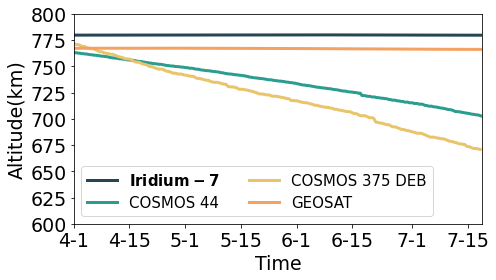

In [12]:
starttime=datetime.datetime(2022,4,1)
endtime=datetime.datetime(2022,7,20)
delta_time=(endtime-starttime).days*24*3600
list1 = [24793,876,4727,15595]
legend_list = [r'$\bf{Iridium-7}$','COSMOS 44','COSMOS 375 DEB','GEOSAT']
plt.figure(1)
fig = plt.figure(figsize=(7,4))
ax = plt.subplot(111)
#legend_list = []
color_list = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51',"#3F72AF","#112D4E"]
for item in list1:
    object_df = object_dict[item]
    object_df = object_df[object_df['EPOCH'] >= datetime.datetime(2022,4,1)]
    object_df = object_df.sort_values(by='EPOCH',ascending=True)
    #legend_list.append(object_dict[item].iloc[0,1])
    time_scale = generate_time_series("2022-4-1 0:0:0", "2022-7-19 23:59:59",len(object_df['EPOCH']))[:-1]
    #print(len(object_df['EPOCH']))
    time_length = len(object_df['EPOCH'])
    if(time_length > len(time_scale)):
        time_length = 264
    #print(object_dict[item])
    plt.plot(time_scale[:time_length],object_df['alltitude'][:time_length],color = color_list[list1.index(item)],lw=3)
plt.legend(legend_list,ncol=2,fontsize = 15)
plt.ylim([600,800])
#ax.xaxis.set_major_locator(MultipleLocator(45))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylabel('Altitude(km)',fontsize = 19)
plt.xlabel('Time',fontsize = 19)
plt.xticks([starttime,starttime+datetime.timedelta(days=15),starttime+datetime.timedelta(days=30),starttime+datetime.timedelta(days=45),starttime+datetime.timedelta(days=60),starttime+datetime.timedelta(days=75),starttime+datetime.timedelta(days=91),starttime+datetime.timedelta(days=106)],['4-1','4-15','5-1','5-15','6-1','6-15','7-1','7-15'])
plt.xlim([starttime,starttime+datetime.timedelta(days=110)])
plt.xticks(fontsize = 19)
plt.yticks(fontsize = 19)
plt.tight_layout()
plt.savefig('iridium-v5.pdf')

257
240
255
261


<Figure size 432x288 with 0 Axes>

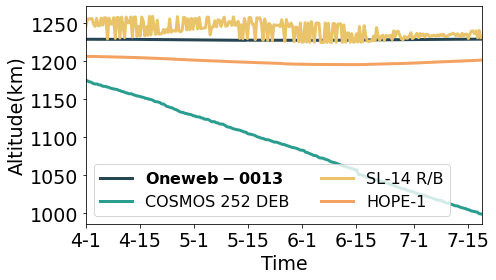

In [11]:
starttime=datetime.datetime(2022,4,1)
endtime=datetime.datetime(2022,7,20)
delta_time=(endtime-starttime).days*24*3600
list2 = [45131,3559,16194,36122]
legend_list = [r'$\bf{Oneweb-0013}$','COSMOS 252 DEB','SL-14 R/B','HOPE-1']
plt.figure(1)
fig = plt.figure(figsize=(7,4))
ax = plt.subplot(111)
color_list = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51',"#3F72AF","#112D4E"]
#legend_list = []
for item in list2:
    object_df = object_dict[item]
    object_df = object_df[object_df['EPOCH'] >= datetime.datetime(2022,4,1)]
    object_df = object_df.sort_values(by='EPOCH',ascending=True)
    #legend_list.append(object_dict[item].iloc[0,1])
    time_scale = generate_time_series("2022-4-1 0:0:0", "2022-7-19 23:59:59",len(object_df['EPOCH']))[:-1]
    print(len(object_df['EPOCH']))
    time_length = len(object_df['EPOCH'])
    if(time_length > len(time_scale)):
        time_length = 264
    #print(object_dict[item])
    plt.plot(time_scale[:time_length],object_df['alltitude'][:time_length],color = color_list[list2.index(item)],lw=3)
plt.legend(legend_list,ncol=2,fontsize = 16)
#plt.ylim([600,830])
#ax.xaxis.set_major_locator(MultipleLocator(45))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylabel('Altitude(km)',fontsize = 19)
plt.xlabel('Time',fontsize = 19)
plt.xticks([starttime,starttime+datetime.timedelta(days=15),starttime+datetime.timedelta(days=30),starttime+datetime.timedelta(days=45),starttime+datetime.timedelta(days=60),starttime+datetime.timedelta(days=75),starttime+datetime.timedelta(days=91),starttime+datetime.timedelta(days=106)],['4-1','4-15','5-1','5-15','6-1','6-15','7-1','7-15'])
plt.xlim([starttime,starttime+datetime.timedelta(days=110)])
plt.xticks(fontsize = 19)
plt.yticks(fontsize = 19)
plt.tight_layout()
plt.savefig('oneweb-v5.pdf')